<a href="https://colab.research.google.com/github/farazjawedd/Explainable-AI/blob/main/Adversarial_AI_FJ.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Step 1: Downloading ImageNet Class Labels

In this step, we download the labels used by the ImageNet dataset. These labels allow us to interpret the predictions made by our neural network.


In [23]:
!wget https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt -O imagenet_classes.txt


--2025-03-16 02:06:17--  https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10472 (10K) [text/plain]
Saving to: ‘imagenet_classes.txt’

imagenet_classes.tx 100%[===================>]  10.23K  --.-KB/s    in 0.001s  

2025-03-16 02:06:18 (14.5 MB/s) - ‘imagenet_classes.txt’ saved [10472/10472]



In [24]:
pwd

'/content'

### Step 2: Importing Libraries & Uploading the Image

Here, we import necessary libraries including PyTorch and torchvision for model handling and transformations. We then upload an image, preprocess it by resizing and converting it to a tensor, preparing it for model input.


In [25]:
import torch
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision import models
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import os

from google.colab import files
uploaded = files.upload()

image_path = list(uploaded.keys())[0]
print(f"✅ Uploaded image: {image_path}")

image = Image.open(image_path).convert("RGB")

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

input_tensor = transform(image).unsqueeze(0)

Saving golden-retriever-dog-breed-info.jpeg to golden-retriever-dog-breed-info (2).jpeg
✅ Uploaded image: golden-retriever-dog-breed-info (2).jpeg


### Step 3: Loading the Pre-trained Model & Making an Initial Prediction

In this cell, we load a pre-trained ResNet-34 model trained on ImageNet data. The model predicts the class label of the input image, providing a baseline prediction before we apply any adversarial perturbations.


In [26]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

input_tensor = transform(image).unsqueeze(0)

model = models.resnet34(weights=models.ResNet34_Weights.IMAGENET1K_V1)
model.eval()

imagenet_classes = models.ResNet34_Weights.IMAGENET1K_V1.meta["categories"]

output = model(input_tensor)
pred_label = imagenet_classes[output.argmax().item()]
print(f"✅ Original Prediction: {pred_label}")


✅ Original Prediction: golden retriever


### Step 4: Creating an Adversarial Patch

We initialize an adversarial patch—a small tensor that we'll optimize to fool the model. We also define a function, `apply_patch`, to apply this patch onto the original image. An optimizer (`Adam`) is set up to iteratively update the patch.


In [27]:
patch_size = (100, 100)

patch = torch.ones(3, *patch_size, requires_grad=True)
x_offset, y_offset = 62, 62

def apply_patch(image_tensor, patch, x_offset, y_offset):
    patched_image = image_tensor.clone()
    patch = patch.unsqueeze(0)
    patched_image[:, :, y_offset:y_offset+patch_size[1], x_offset:x_offset+patch_size[0]] = patch
    return patched_image

optimizer = torch.optim.Adam([patch], lr=0.05)


### Step 5: Optimizing the Adversarial Patch

Here, we perform optimization over multiple iterations (1000 steps). Our goal is to modify the patch so that the neural network misclassifies the patched image as a specified target class (class index 609 - jeans in this example). We periodically print the loss to track the progress of the optimization.

We also check how the optimization process works, by printing the patch after every 100 iterations.

After optimization, we visualize both the original and adversarially patched images side-by-side to compare the model's predictions. Finally, we save the optimized adversarial patch as an image file.


Iteration: 100, Loss: -88.6488265991211


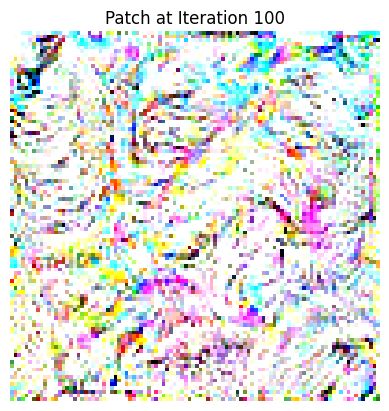

Iteration: 200, Loss: -99.9788818359375


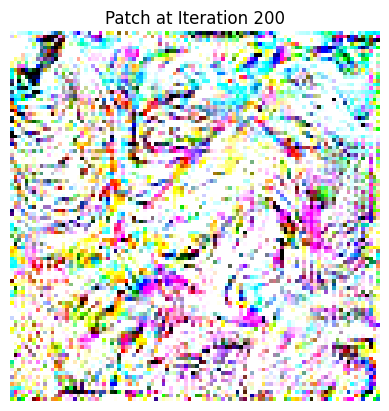

Iteration: 300, Loss: -104.8867416381836


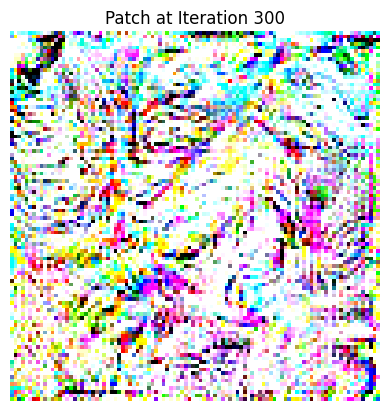

Iteration: 400, Loss: -108.3329849243164


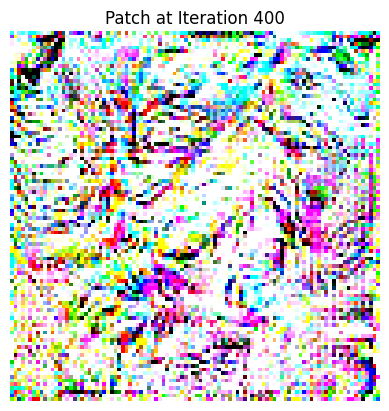

Iteration: 500, Loss: -111.21570587158203


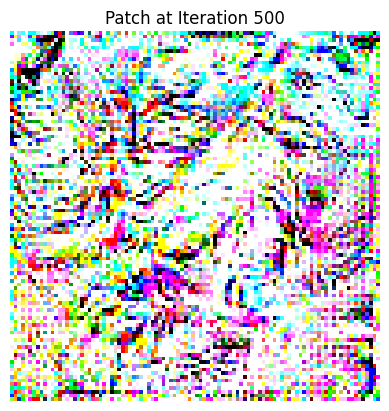

Iteration: 600, Loss: -113.00287628173828


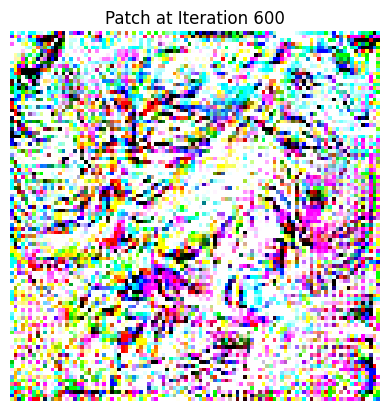

Iteration: 700, Loss: -114.73136138916016


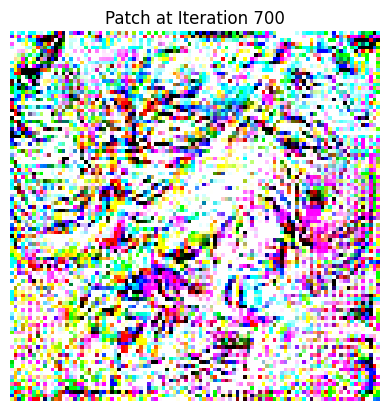

Iteration: 800, Loss: -116.03519439697266


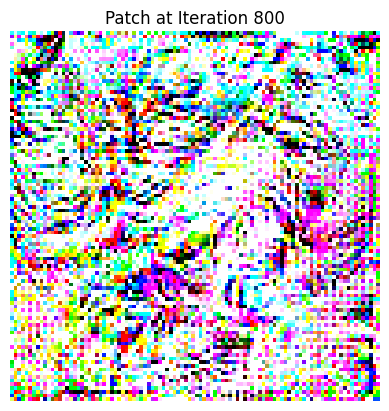

Iteration: 900, Loss: -117.13860321044922


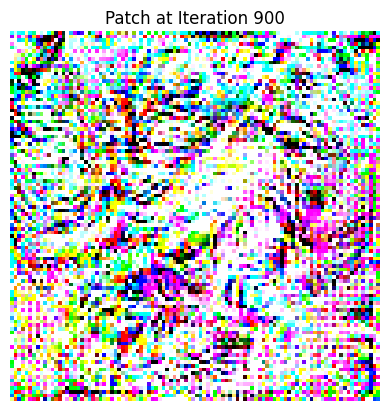

Iteration: 1000, Loss: -118.09402465820312


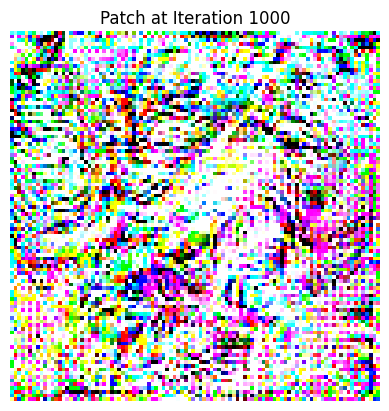

🚀 Adversarial Prediction: paper towel


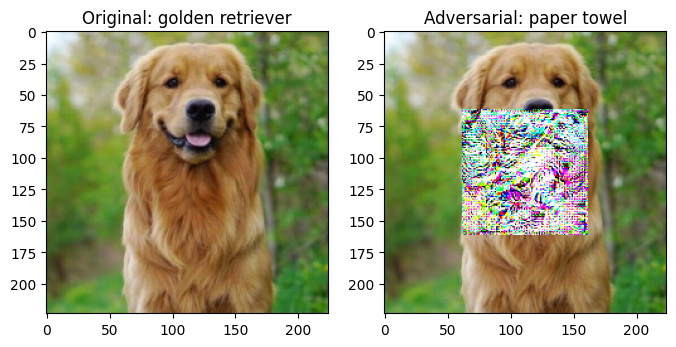

✅ Patch saved as adversarial_patch.png


In [28]:
target_class = 609 # jeans

for i in range(1000):
    patched_image = apply_patch(input_tensor, patch, x_offset, y_offset)
    output = model(patched_image)

    loss = -F.cross_entropy(output, torch.tensor([target_class], dtype=torch.long))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (i+1) % 100 == 0:
        print(f'Iteration: {i+1}, Loss: {loss.item()}')
        plt.imshow(patch.detach().permute(1, 2, 0).cpu().numpy())
        plt.title(f'Patch at Iteration {i+1}')
        plt.axis('off')
        plt.show()

patched_output = model(apply_patch(input_tensor, patch, x_offset, y_offset))
patched_pred_label = imagenet_classes[patched_output.argmax().item()]
print(f"🚀 Adversarial Prediction: {patched_pred_label}")

plt.figure(figsize=(8,4))

# Original image
plt.subplot(1,2,1)
plt.imshow(input_tensor.squeeze().permute(1,2,0).detach().cpu().numpy())
plt.title(f"Original: {pred_label}")

# Patched image
plt.subplot(1,2,2)
plt.imshow(apply_patch(input_tensor, patch, x_offset, y_offset).squeeze().permute(1,2,0).detach().cpu().numpy())
plt.title(f"Adversarial: {patched_pred_label}")

plt.show()


patch_image = patch.detach().squeeze().permute(1,2,0).cpu().numpy()

patch_image = np.clip(patch_image, 0, 1)

# Save the patch as an image
plt.imsave("adversarial_patch.png", patch_image)
print("✅ Patch saved as adversarial_patch.png")



Although, the intended patch was jeans, the prediction comes out to be paper towel